# Import

In [1]:
import csv
import os
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from smart_open import open

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
tqdm.pandas()

# Read data

In [3]:
newsgroups_df = pd.read_csv("../../../Preprocessing/data/AgNews/master.csv", index_col=0)

In [4]:
with open("../../../Preprocessing/data/AgNews/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [5]:
vector_sizes = [2, 3, 4, 6, 7, 8, 9, 10, 20, 40, 80, 160, 320, 640]

In [6]:
class Corpus:
    def __init__(self, path=None, texts=None):
        self.path = path
        self.texts = texts
        self.dictionary = Dictionary(texts)

    def __iter__(self):
        if self.path is not None:
            for line in open(self.path):
                # assume there's one document per line, tokens separated by whitespace
                yield self.dictionary.doc2bow(line.lower().split())
        else:
            for line in self.texts:
                yield self.dictionary.doc2bow(line)

In [7]:
texts = newsgroups_df.words_nonstop.progress_apply(lambda x: x.split(' ')).tolist()
corpus = Corpus(texts=texts)
dictionary = Dictionary(texts)

100%|██████████| 120000/120000 [00:01<00:00, 84473.00it/s] 


In [8]:
label = newsgroups_df["class"].to_numpy()

In [9]:
model_nums = 1
vector_model_num = 0

In [14]:
vectors_path = "../../../Clustering/data/AgNews/doc2vec/vector/"
models_path = "../../../Clustering/data/AgNews/doc2vec/KMeans/model/"
pred_path = "../../../Clustering/data/AgNews/doc2vec/KMeans/pred/"

coherences = []
for model_num in range(model_nums):
    coherence = []
    for vector_size in tqdm(vector_sizes):
        vector_path = f"{vectors_path}{vector_size}/normalized/{vector_model_num}.csv"
        vectors = np.loadtxt(vector_path, delimiter=",")

        gmm = pickle.load(open(f"{models_path}{vector_size}/{model_num}.sav", "rb"))
        pred = gmm.predict(vectors)

        cm = CoherenceModel(
            topics=pred.reshape(1, -1),
            corpus=corpus,
            dictionary=dictionary,
            texts=texts,
            coherence="c_v",
        )
        coherence.append(cm.get_coherence())
    coherences.append(coherence)
    

100%|██████████| 14/14 [22:49<00:00, 97.83s/it] 


In [24]:
newsgroups_df.head()

,class,title,text,words,words_nonstop
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...","Reuters - Short-sellers , Wall Street 's dwind...","Reuters - Short-sellers , Wall Street 's dwind..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Reuters - Private investment firm Carlyle Grou...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Reuters - Soaring crude prices plus worries\ab...,Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Reuters - Authorities have halted oil export\f...,Reuters - Authorities halted oil export\flows ...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","AFP - Tearaway world oil prices , toppling rec...","AFP - Tearaway world oil prices , toppling rec..."


In [16]:
pd.DataFrame(coherences, columns=vector_sizes).T

,0
2,0.836844
3,0.609973
4,0.691280
6,0.655740
7,0.813194
8,0.685397
9,0.740923
10,0.746303
20,0.816419
40,0.741379


<AxesSubplot: >

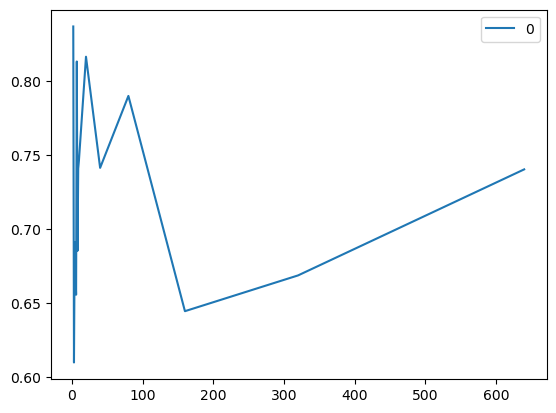

In [17]:
pd.DataFrame(coherences, columns=vector_sizes).T.plot()

<AxesSubplot: >

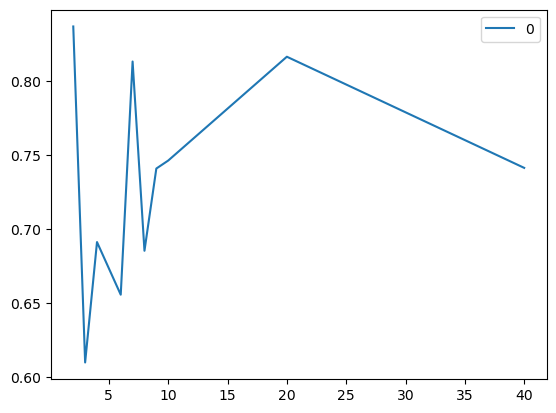

In [23]:
pd.DataFrame(coherences, columns=vector_sizes).loc[:, :40].T.plot()